In [249]:
import os
import torch
import cv2
from ultralytics import YOLO
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import pandas as pd
import csv

In [250]:
model_path = '../datasets/shopping-trolley-5/runs/detect/pretrainedv8n/weights/bestpretrainedv8n.pt'
# model_path = '../datasets/shopping-trolley-5/runs/detect/unpretrainedv8n/weights/bestpretrainedv8n.pt'
image_path = '../shopping-trolley-5/test/images'
label_path = '../shopping-trolley-5/test/labels'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = YOLO(model_path)
model = model.to(device)
# model.eval()

In [251]:
def predict_images(image_dir):
    predictions = []
    images = []
    filenames = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            path = os.path.join(image_dir, filename)
            image = cv2.imread(path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_tensor = torch.from_numpy(image).float() / 255.0
            image_tensor = image_tensor.permute(2, 0, 1).unsqueeze(0)

            # print(image, image.shape)
            with torch.no_grad():
                detections = model(image_tensor, verbose=False)
                predictions.append(detections[0].boxes.xywh / 640)
            
            images.append(image_tensor)
            filenames.append(filename)

    return predictions, images, filenames
            
def load_labels(label_dir):
    labels = []
    for filename in os.listdir(label_dir):
        if filename.endswith('.txt'):
            path = os.path.join(label_dir, filename)
            with open(path, 'r') as file:
                labels[filename[:-4]] = file.readlines()
    return labels

def compute_metrics(predictions, true_labels):
    return 0

In [252]:
def print_ground(filename, label_path):
    # TO SAVE ALL GROUNDS INTO CSV FILE
    path = os.path.join(label_path, filename + '.txt')
    bounding_boxes = [] 
    with open(path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            components = line.strip().split()
            if len(components) >= 5:
                x = float(components[1])
                y = float(components[2])
                w = float(components[3])
                h = float(components[4])
                bounding_boxes.append([x, y, w, h])

    return np.array(bounding_boxes)

def write_to_csv(filenames, predictions, label_path, csv_filename):
    with open(csv_filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Filename', 'Type', 'x', 'y', 'w', 'h'])

        for i in range(len(predictions)):
            filename_base = filenames[i][:-4]

            ground_truths = print_ground(filename_base, label_path)
            for ground in ground_truths:
                writer.writerow([filenames[i], 'Ground'] + ground.tolist())

            if len(predictions[i]) > 0:
                for prediction in predictions[i]:
                    writer.writerow([filenames[i], 'Predicted'] + prediction.tolist())
            else:
                writer.writerow([filenames[i], 'Predicted', '-1', '-1', '-1', '-1'])


In [253]:
predictions, image, filenames = predict_images(image_path)
# labels = load_labels(label_path)
write_to_csv(filenames, predictions, label_path, 'result.csv')
data = pd.read_csv('result.csv')

In [254]:
def calculate_iou(box1, box2):
    """Calculate the Intersection over Union (IoU) of two bounding boxes."""
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0  # No overlap

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = area1 + area2 - intersection_area
    iou = intersection_area / union_area
    return iou

def match_predictions_to_ground_truths(ground_boxes, predicted_boxes, iou_threshold=0.5):
    """Match predictions to ground truths based on the IoU threshold."""
    matches = []
    used_predictions = set()

    for i, ground_box in enumerate(ground_boxes):
        best_iou = 0
        best_pred_index = -1

        for j, predicted_box in enumerate(predicted_boxes):
            if j in used_predictions:
                continue
            iou = calculate_iou(ground_box, predicted_box)
            if iou > best_iou:
                best_iou = iou
                best_pred_index = j

        if best_iou > iou_threshold and best_pred_index != -1:
            matches.append((i, best_pred_index, best_iou))
            used_predictions.add(best_pred_index)

    return matches


def draw_bboxes_and_calculate_iou(image_path, grounds, predictions):
    image = Image.open(image_path)
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    ax = plt.gca()

    ground_boxes = []
    predicted_boxes = []

    for index, row in grounds.iterrows():
        x1 = (row['x'] - row['w'] / 2) * image.width
        y1 = (row['y'] - row['h'] / 2) * image.height
        x2 = (row['x'] + row['w'] / 2) * image.width
        y2 = (row['y'] + row['h'] / 2) * image.height
        ground_boxes.append((x1, y1, x2, y2))
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    for index, row in predictions.iterrows():
        x1 = (row['x'] - row['w'] / 2) * image.width
        y1 = (row['y'] - row['h'] / 2) * image.height
        x2 = (row['x'] + row['w'] / 2) * image.width
        y2 = (row['y'] + row['h'] / 2) * image.height
        predicted_boxes.append((x1, y1, x2, y2))
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='green', facecolor='none')
        ax.add_patch(rect)

    plt.axis("off")
    plt.show()

    matches = match_predictions_to_ground_truths(ground_boxes, predicted_boxes)
    for match in matches:
        ground_idx, pred_idx, iou = match
        print(f"IoU between Ground Box {ground_idx} and Prediction Box {pred_idx}: {iou:.4f}")


In [255]:
def convert_to_corners(x, y, w, h, image_width, image_height):
    x1 = (x - w / 2) * image_width
    y1 = (y - h / 2) * image_height
    x2 = (x + w / 2) * image_width
    y2 = (y + h / 2) * image_height
    return x1, y1, x2, y2

def calculate_image_iou(ground_boxes, predicted_boxes):
    iou_scores = []
    used_predictions = set()

    for i, ground_box in enumerate(ground_boxes):
        best_iou = 0
        best_pred_index = -1

        for j, predicted_box in enumerate(predicted_boxes):
            if j in used_predictions:
                continue
            iou = calculate_iou(ground_box, predicted_box)
            if iou > best_iou:
                best_iou = iou
                best_pred_index = j

        if best_iou > 0:  # Only consider positive IoUs to calculate mean
            iou_scores.append(best_iou)
            used_predictions.add(best_pred_index)

    return np.mean(iou_scores) if iou_scores else 0

def overall_dataset_iou(data):
    filenames = data['Filename'].unique()
    overall_iou = []

    image_width = 640 # TODO: Adjust!
    image_height = 640 # TODO: Adjust!

    for filename in filenames:
        ground_data = data[(data['Filename'] == filename) & (data['Type'] == 'Ground')]
        pred_data = data[(data['Filename'] == filename) & (data['Type'] == 'Predicted')]

        ground_boxes = [convert_to_corners(row['x'], row['y'], row['w'], row['h'], image_width, image_height) for index, row in ground_data.iterrows()]
        predicted_boxes = [convert_to_corners(row['x'], row['y'], row['w'], row['h'], image_width, image_height) for index, row in pred_data.iterrows()]

        file_iou = calculate_image_iou(ground_boxes, predicted_boxes)
        overall_iou.append(file_iou)

    return np.mean(overall_iou)

iou_result = overall_dataset_iou(data)
print(f"The overall mean IoU for the dataset is: {iou_result:.4f}")

The overall mean IoU for the dataset is: 0.8739


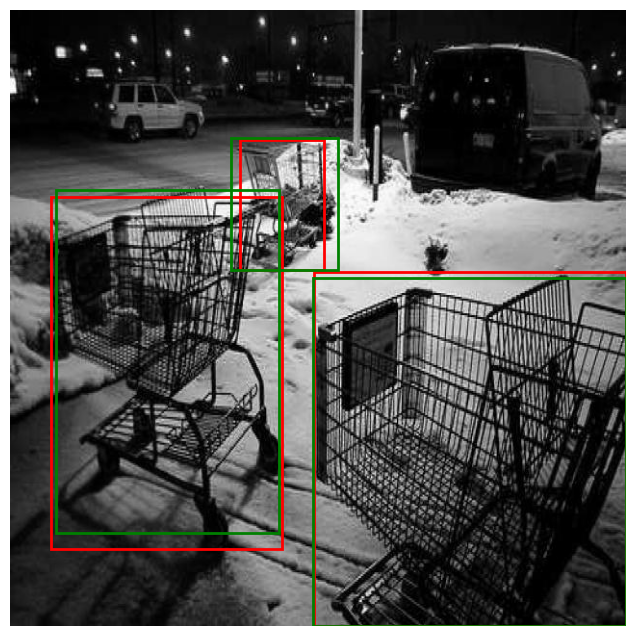

IoU between Ground Box 0 and Prediction Box 1: 0.9058
IoU between Ground Box 1 and Prediction Box 0: 0.9776
IoU between Ground Box 2 and Prediction Box 2: 0.7746


In [256]:
filename = "JBTJHN03X8PX_jpg.rf.551346478617b2500a36654b07c5028d.jpg"

grounds = data[(data['Filename'] == filename) & (data['Type'] == 'Ground')]
predictions = data[(data['Filename'] == filename) & (data['Type'] == 'Predicted')]

image_path = os.path.join(image_path, filename)
draw_bboxes_and_calculate_iou(image_path, grounds, predictions)
